<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/UV_Stellar_Catalog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install**

In [1]:
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet
!pip install synphot --quiet

     |████████████████████████████████| 914 kB 13.9 MB/s 


# **GitHub**

In [2]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 1289, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 1289 (delta 91), reused 96 (delta 51), pack-reused 1124
Receiving objects: 100% (1289/1289), 189.07 MiB | 25.94 MiB/s, done.
Resolving deltas: 100% (703/703), done.


In [3]:
cd INSIST/data

/content/INSIST/data


#**Imports**

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from astropy.table import Table
from astropy.io import fits

import os
from time import perf_counter
import json
import requests
from scipy.interpolate import interp1d
from scipy import integrate

import mastcasjobs
from scipy.optimize import minimize_scalar,minimize

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

matplotlib.rcParams['font.size']=15
matplotlib.rcParams['figure.figsize']=(15,10)
sb.set_style('darkgrid')

# **Data**

## **CasJobs Script**

In [5]:
def mastQuery(request, json_return=False):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [6]:
class casjobs():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None ,cols = None):   

        if name is not None and df is None:
          self.name = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
          self.query =   f"""select psc.objid,o.raStack,o.decStack,mag.gPSFMag, mag.gPSFMagErr,mag.rPSFMag, mag.rPSFMagErr,mag.iPSFMag, mag.iPSFMagErr,mag.zPSFMag,mag.zPSFMagErr, mag.yPSFMag,mag.yPSFMagErr,psc.ps_score
                            from fGetNearbyObjEq({self.ra}, {self.dec}, 28) f
                            join ObjectThin o on o.objid=f.objid
                            join HLSP_PS1_PSC.pointsource_scores psc on psc.objid=f.objid
                            join StackObjectThin mag on mag.objid=psc.objid
                            WHERE
                            mag.gPSFMag>-900 and 
                            mag.rPSFMag>-900 and 
                            mag.iPSFMag>-900 and 
                            mag.zPSFMag>-900 and 
                            mag.yPSFMag>-900 
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()
        else:
          self.df = df 
        if cols is not None:
          self.df = self.df.rename(columns=cols) 
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df['ra'],self.df['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n  {len(self.df)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
        

## **M 31**

In [35]:
df_M31 = Table.read('/content/INSIST/data/M31_UVIT_PanSTARRS_crossmatch.fits').to_pandas()

In [36]:
df_star = df_M31[df_M31['ps_score']>0.5][:1].copy()
df_star =  df_star.rename(columns = {'raStack':'ra','decStack':'dec'})

In [37]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000             # mJy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])/1.082        # mJy

In [38]:
df_star['NUVFlux']     = 3631*pow(10,-df_star['NUV']/2.5)*1000             # mJy
df_star['NUVFlux_err'] = (df_star['NUV_err']*df_star['NUVFlux'])/1.082        # mJy

df_star['FUVFlux']     = 3631*pow(10,-df_star['FUV']/2.5)*1000             # mJy
df_star['FUVFlux_err'] = (df_star['FUV_err']*df_star['FUVFlux'])/1.082        # mJy

In [39]:
df_star['objid'] = [str(i) for i in df_star['objid']]

In [40]:
df_star

,RAJ2000,DEJ2000,FUV,FUV_err,NUV,NUV_err,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,...,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err,NUVFlux,NUVFlux_err,FUVFlux,FUVFlux_err
0,10.8947,41.3926,21.499,19.098,20.857,0.188,20.7313,0.02506,20.9541,0.033309,...,0.007752,0.000566,0.010246,0.001246,0.005421,0.002719,0.01649,0.002865,0.009129,0.161134


# **Synthetic Spectra**

## **Synphot**

#### **Model**

In [ ]:
os.environ['PYSYN_CDBS'] = '/content/INSIST/data'

In [ ]:
!mkdir '/content/INSIST/data/grid'

mkdir: cannot create directory ‘/content/INSIST/data/grid’: File exists


In [ ]:
cd '/content/INSIST/data/grid/'

/content/INSIST/data/grid


In [ ]:
!wget http://ssb.stsci.edu/trds/tarfiles/synphot3.tar.gz

--2022-06-10 11:22:54--  http://ssb.stsci.edu/trds/tarfiles/synphot3.tar.gz
Resolving ssb.stsci.edu (ssb.stsci.edu)... 130.167.165.20
Connecting to ssb.stsci.edu (ssb.stsci.edu)|130.167.165.20|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ssb.stsci.edu/trds/tarfiles/synphot3.tar.gz [following]
--2022-06-10 11:22:54--  https://ssb.stsci.edu/trds/tarfiles/synphot3.tar.gz
Connecting to ssb.stsci.edu (ssb.stsci.edu)|130.167.165.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18076806 (17M) [application/octet-stream]
Saving to: ‘synphot3.tar.gz.1’

synphot3.tar.gz.1   100%[===================>]  17.24M  31.0MB/s    in 0.6s    

2022-06-10 11:22:55 (31.0 MB/s) - ‘synphot3.tar.gz.1’ saved [18076806/18076806]



In [ ]:
!tar -xf synphot3.tar.gz

In [ ]:
!cp -a /content/INSIST/data/grid/grp/redcat/trds/grid/ck04models /content/INSIST/data/grid/

In [ ]:
!rm -r grp

In [ ]:
cat = Table.read('ck04models/catalog.fits')

In [ ]:
filter_dict = {'PS1g'    : [4881.47, 'PAN-STARRS_PS1.g.dat' ],
               'PS1r'    : [6198.41, 'PAN-STARRS_PS1.r.dat' ],
               'PS1i'    : [7549.34, 'PAN-STARRS_PS1.i.dat' ],
               'PS1z'    : [8701.37, 'PAN-STARRS_PS1.z.dat' ],
               'PS1y'    : [9509.80,'PAN-STARRS_PS1.y.dat' ],
               'UVIT_NUV': [2792.56,'Astrosat_UVIT.N279N.dat'],
               'UVIT_FUV': [1506.00,'Astrosat_UVIT.F148Wa.dat']}

#### **Convolving Filters**

In [ ]:
df = cat[['INDEX']][:10]
conv_fluxes = []
for f in cat['FILENAME'][:10]:
  wav = Table.read(f'ck04models/ckm05/ckm05_10000.fits')['WAVELENGTH'].value
  l = f.split('[')
  name        = l[0]
  col         = l[1][:3]
  tab         = Table.read(f'ck04models/{name}')
  flux        = tab[col].value # 
  model_func  = interp1d(wav,flux)
  fluxes      = []
  for filter in filter_dict:
    file_name = filter_dict[filter][1]
    filt_dat  = np.loadtxt(f'/content/INSIST/data/{file_name}')

    x         = filt_dat[:,0]
    y         = filt_dat[:,1]
    
    indices  = np.where( (wav>x[0]) & (wav<x[-1]))
    wav_new  = wav[indices]
    flux_new = flux[indices]

    x_new = [wav[0]] + [x[0]-1] + list(x) + [x[-1]+1] + [wav[-1]]
    y_new = [0]      + [0]      + list(y) +     [0]   + [0]
    
    filt_func = interp1d(x_new,y_new)

    filt_flux = model_func(wav)*filt_func(wav)

    const     = integrate.simps(filt_flux*wav,wav)/integrate.simps(filt_func(wav)*wav, wav)

    filt_flux = interp1d(wav, filt_flux)    # erg/(s.cm2.A)

    lambd = filter_dict[filter][0]                            
 
    filt_flux_Jy =  (const*(lambd)**2*3.34e7)

    fluxes.append(filt_flux_Jy)
  conv_fluxes.append(fluxes)

conv_fluxes = np.array(conv_fluxes)

Text(0, 0.5, 'Flux | Response')

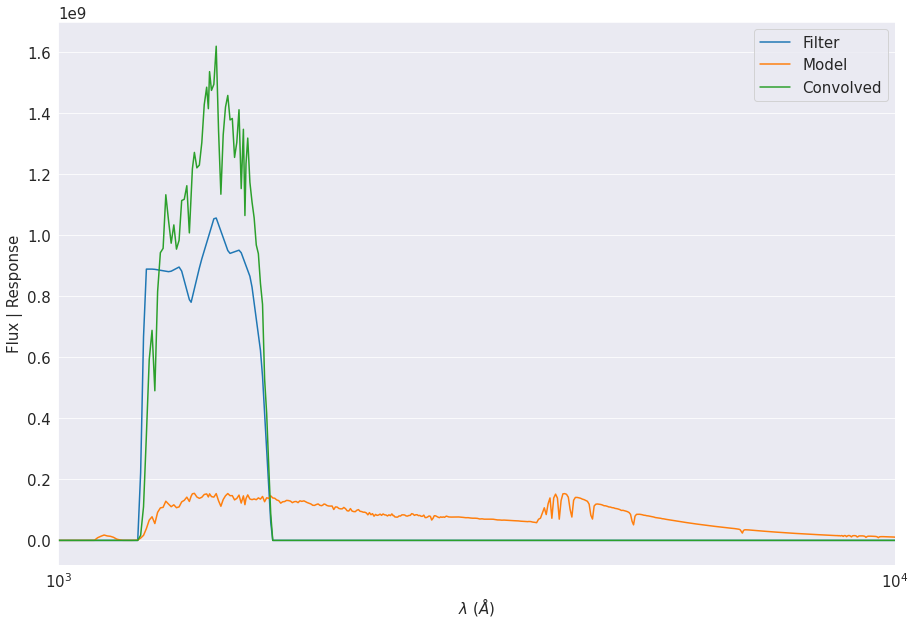

In [ ]:
plt.plot(wav, filt_func(wav)*1e8)
plt.plot(wav, model_func(wav))
plt.plot(wav, filt_flux(wav))
plt.xscale('log')
plt.xlim(1e3,1e4)
plt.legend(['Filter','Model','Convolved'])
plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel('Flux | Response')

In [ ]:
for i, filter in enumerate(filter_dict):
  df[filter] = conv_fluxes[:,i]

In [ ]:
df.write('PanSTARRS_UVIT_conv.fits', overwrite = True)

In [11]:
tab = Table.read('PanSTARRS_UVIT_conv.fits')

In [12]:
model_df = tab.to_pandas()

In [13]:
model_df

,INDEX,T,Met,logg,PS1gflux,PS1gmag,PS1rflux,PS1rmag,PS1iflux,PS1imag,...,PS1i_flux,PS1i_mag,PS1z_flux,PS1z_mag,PS1y_flux,PS1y_mag,UVIT_NUV_flux,UVIT_NUV_mag,UVIT_FUV_flux,UVIT_FUV_mag
0,"b'10000,-0.5,0.0 '",10000.0,-0.5,0.0,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf,...,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf
1,"b'10000,-0.5,0.5 '",10000.0,-0.5,0.5,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf,...,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf
2,"b'10000,-0.5,1.0 '",10000.0,-0.5,1.0,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf,...,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf
3,"b'10000,-0.5,1.5 '",10000.0,-0.5,1.5,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf,...,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf,0.000000e+00,inf
4,"b'10000,-0.5,2.0 '",10000.0,-0.5,2.0,6.930797e+22,-40.701892,5.508034e+22,-40.452426,4.467290e+22,-40.225045,...,4.467290e+22,-40.225045,4.035269e+22,-40.114616,3.658205e+22,-40.008105,1.956947e+22,-39.328882,8.701942e+21,-38.448975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6683,"b'9750,0.5,3.0 '",9750.0,0.5,3.0,7.168703e+22,-40.738536,5.567871e+22,-40.464157,4.446867e+22,-40.220070,...,4.446867e+22,-40.220070,3.952551e+22,-40.092128,3.663655e+22,-40.009721,1.455237e+22,-39.007269,5.022816e+21,-37.852303
6684,"b'9750,0.5,3.5 '",9750.0,0.5,3.5,7.152636e+22,-40.736100,5.572779e+22,-40.465114,4.460427e+22,-40.223375,...,4.460427e+22,-40.223375,3.914202e+22,-40.081542,3.645267e+22,-40.004258,1.504988e+22,-39.043767,4.969031e+21,-37.840614
6685,"b'9750,0.5,4.0 '",9750.0,0.5,4.0,7.111748e+22,-40.729875,5.590702e+22,-40.468600,4.493287e+22,-40.231345,...,4.493287e+22,-40.231345,3.891096e+22,-40.075114,3.625295e+22,-39.998293,1.572713e+22,-39.091558,4.733782e+21,-37.787955
6686,"b'9750,0.5,4.5 '",9750.0,0.5,4.5,7.051201e+22,-40.720592,5.617236e+22,-40.473741,4.538991e+22,-40.242333,...,4.538991e+22,-40.242333,3.884165e+22,-40.073179,3.602792e+22,-39.991532,1.651050e+22,-39.144335,4.328091e+21,-37.690675


#### **$Chi^2$ Fitting**

In [95]:
def chi2_func(Md,flux,model_flux,flux_err):
  chi = (flux - pow(10,Md)*model_flux)/flux_err
  return chi@chi

In [96]:
chi_set = []
for i,row_source in df_star.iterrows():

  flux     = row_source[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux','yPSFFlux']].values
  flux_err = row_source[['gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err', 'yPSFFlux_err']].values

  for j, row_model in model_df.iterrows():

    model_flux = row_model[['PS1gflux','PS1rflux','PS1iflux','PS1zflux','PS1yflux']].values

    Md = minimize_scalar(chi2_func,args=(flux, model_flux, flux_err)).x
    chi2       = chi2_func(Md,flux,model_flux,flux_err)
    chi_set.append([row_source['objid'],row_model['T'],row_model['Met'],row_model['logg'],Md,chi2])

In [97]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','T','Met','logg','Md','chi2'])

In [98]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [99]:
df_chi_min

,objid,T,Met,logg,Md,chi2
6044,157670108946911614,18000.0,0.5,2.5,-25.10903,33.221312


In [100]:
df_out = pd.merge(df_chi_min, model_df, on = ['T','Met','logg'])

In [101]:
for i in ['PS1gflux','PS1rflux','PS1iflux','PS1zflux', 'PS1yflux','UVIT_FUV_flux', 'UVIT_NUV_flux']:
  df_out[i]*=pow(10,df_out['Md'].values)
  df_out[i[:-4]+'_mag_p'] = -2.5*np.log10(df_out[i]/3631000)

In [102]:
df_final = pd.merge(df_star,df_out, on = 'objid')

In [103]:
df_final

,RAJ2000,DEJ2000,FUV,FUV_err,NUV,NUV_err,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,...,UVIT_NUV_mag,UVIT_FUV_flux,UVIT_FUV_mag,PS1g_mag_p,PS1r_mag_p,PS1i_mag_p,PS1z_mag_p,PS1y_mag_p,UVIT_FUV__mag_p,UVIT_NUV__mag_p
0,10.8947,41.3926,21.499,19.098,20.857,0.188,20.7313,0.02506,20.9541,0.033309,...,-42.307329,0.016262,-41.900472,20.707778,21.080903,21.396018,21.627301,21.817547,20.872102,20.465246


In [104]:
obs_mag = ['FUV','NUV','gPSFMag', 'rPSFMag', 'iPSFMag','zPSFMag',  'yPSFMag', ]
mod_mag = ['UVIT_FUV__mag_p', 'UVIT_NUV__mag_p','PS1g_mag_p','PS1r_mag_p', 'PS1i_mag_p', 'PS1z_mag_p',  'PS1y_mag_p']

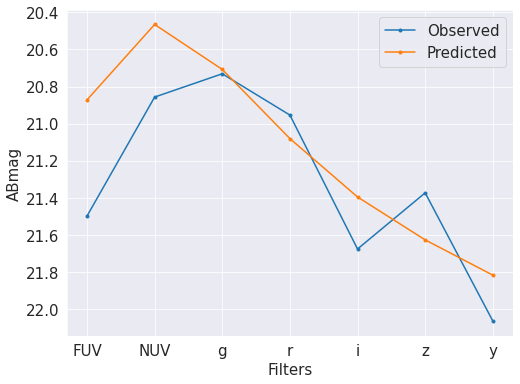

In [109]:
fig, ax = plt.subplots(figsize = (8,6))
n = 0
ax.plot(df_final[obs_mag].values[n],'.-',label = 'Observed' )
ax.plot(df_final[mod_mag].values[n],'.-',label = 'Predicted')
ax.set_xticks(range(7))
ax.set_xticklabels(['FUV','NUV','g', 'r', 'i','z','y'])
ax.set_xlabel('Filters')
ax.set_ylabel('ABmag')
ax.legend()
ax.invert_yaxis()

### **With Av**

In [110]:
def chi2_func(params,flux,model_flux,flux_err,ext):
  Md, av = params
  chi = (flux - pow(10,Md)*model_flux*pow(10,-0.4*av*ext))/flux_err
  return chi@chi

In [111]:
ext = np.array([1.17, 0.873, 0.664, 0.533,0.456])

chi_set = []
for i,row_source in df_star.iterrows():

  flux     = row_source[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux','yPSFFlux']].values
  flux_err = row_source[['gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err', 'yPSFFlux_err']].values

  for j, row_model in model_df.iterrows():

    model_flux = row_model[['PS1gflux','PS1rflux','PS1iflux','PS1zflux','PS1yflux']].values

    params = minimize(chi2_func,x0 = (-25,0.5),bounds=([-30,-10],[0,20]),args=(flux,model_flux,flux_err,ext)).x
    Md, Av = params
    chi2   = chi2_func(params,flux,model_flux,flux_err,ext)
    chi_set.append([row_source['objid'],row_model['T'],row_model['Met'],row_model['logg'],Md,chi2,Av])

In [112]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','T','Met','logg','Md','chi2','Av'])

In [113]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [114]:
df_chi_min

,objid,T,Met,logg,Md,chi2,Av
6044,157670108946911614,18000.0,0.5,2.5,-25.106492,33.217478,0.006157


In [115]:
df_out = pd.merge(df_chi_min, model_df, on = ['T','Met','logg'])

In [116]:
ext = np.array([2.67,1.95,1.17, 0.873, 0.664, 0.533,0.456])
for i, id in enumerate(['UVIT_FUV_flux', 'UVIT_NUV_flux','PS1gflux','PS1rflux','PS1iflux','PS1zflux', 'PS1yflux']):
  df_out[id]*= pow(10,df_out['Md'].values)*pow(10,-0.4*df_out['Av'].values*ext[i])
  df_out[id[:-4]+'_mag_p'] = -2.5*np.log10(df_out[id]/3631000)

In [117]:
df_final = pd.merge(df_star,df_out, on = 'objid')

In [118]:
obs_mag = ['FUV','NUV','gPSFMag', 'rPSFMag', 'iPSFMag','zPSFMag',  'yPSFMag', ]
mod_mag = ['UVIT_FUV__mag_p', 'UVIT_NUV__mag_p','PS1g_mag_p','PS1r_mag_p', 'PS1i_mag_p', 'PS1z_mag_p',  'PS1y_mag_p']

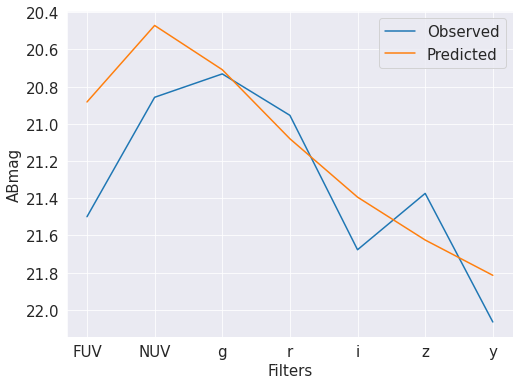

In [119]:
fig, ax = plt.subplots(figsize = (8,6))
n = 0
ax.plot(df_final[obs_mag].values[n],label = 'Observed' )
ax.plot(df_final[mod_mag].values[n],label = 'Predicted')
ax.set_xticks(range(7))
ax.set_xticklabels(['FUV','NUV','g', 'r', 'i','z','y'])
ax.set_xlabel('Filters')
ax.set_ylabel('ABmag')
ax.legend()
ax.invert_yaxis()